# SPOTTING ANAMOLIES IN CHEST X-RAYS

Deep learning can be effectively used for spotting anomalies in X-rays to detect various diseases

In [ ]:
Effusion - liquid starts depositing in the lung (Plural Effusion?)

# Imports & Data Loading

In [5]:
from skimage import io
import os
import glob
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter('ignore')

In [ ]:
# function to plot n images using subplots
def plot_image(images, captions=None, cmap=None ):
    f, axes = plt.subplots(1, len(images), sharey=True)
    f.set_figwidth(15)
    for ax,image in zip(axes, images):
        ax.imshow(image, cmap)

In [8]:
# path to your dataset
DATASET_PATH = './CXR_data'
disease_cls = ['effusion', 'nofinding']

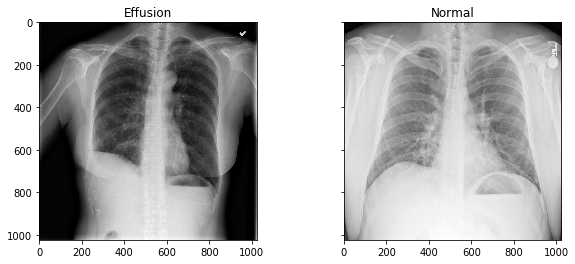

In [17]:
# Read the data
effusion_path = os.path.join(DATASET_PATH, disease_cls[0], '*')
effusion = glob.glob(effusion_path)
effusion = io.imread(effusion[0])

normal_path = os.path.join(DATASET_PATH, disease_cls[1], '*')
normal = glob.glob(normal_path)
normal = io.imread(normal[0])

f, axes = plt.subplots(1, 2, sharey=True)
f.set_figwidth(10)
    
axes[0].title.set_text('Effusion')
axes[0].imshow(effusion, cmap='gray')
axes[1].title.set_text('Normal')
axes[1].imshow(normal, cmap='gray')

In [10]:
effusion.shape

(1024, 1024)

In [11]:
normal.shape

(1024, 1024)

# DATA PREPROCESSING

## Normalisation, Scaling & Augmentation 

Normalisation:
- Standard normalisation applied

Scaling: 
- 1/4th here – from 1024x1024 to 256x256

Augmentation:
- Cannot do vertical flip (upside down) as the orientation is important. 
- Cannot consider only the center part as the anamoly could be outside this
- Here it is random augmentation of few images so that the batch size does not change. 
- Image size is 256x256, can get computationally expensive if all the images are augmented
- np.random.randn() – random number between 0 & 1 from a normal distribution

In [26]:
from skimage.transform import rescale
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=10,
    width_shift_range=0,
    height_shift_range=0,
    vertical_flip=False,)

def preprocess_img(img, mode):
    img = (img - img.min())/(img.max() - img.min())
    img = rescale(img, 0.25, multichannel=True, mode='constant')
    
    if mode == 'train':
        if np.random.randn() > 0:
            img = datagen.random_transform(img)
    return img

# MODEL BUILDING


In [27]:
import resnet

img_channels = 1
img_rows = 256
img_cols = 256

nb_classes = 2

In [28]:
import numpy as np
import tensorflow as tf

class AugmentedDataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, mode='train', ablation=None, disease_cls = ['nofinding', 'effusion'], 
                 batch_size=32, dim=(256, 256), n_channels=1, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = {}
        self.list_IDs = []
        self.mode = mode
        
        for i, cls in enumerate(disease_cls):
            paths = glob.glob(os.path.join(DATASET_PATH, cls, '*'))
            brk_point = int(len(paths)*0.8)
            if self.mode == 'train':
                paths = paths[:brk_point]
            else:
                paths = paths[brk_point:]
            if ablation is not None:
                paths = paths[:int(len(paths)*ablation/100)]
            self.list_IDs += paths
            self.labels.update({p:i for p in paths})
        
            
        self.n_channels = n_channels
        self.n_classes = len(disease_cls)
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'

        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)
        
        delete_rows = []

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            img = io.imread(ID)
            img = img[:, :, np.newaxis]
            if img.shape == (1024, 1024,1):
                img = preprocess_img(img, self.mode)
                X[i,] = img
                y[i] = self.labels[ID]
            else:
                delete_rows.append(i)
                continue
                
        X = np.delete(X, delete_rows, axis=0)
        y = np.delete(y, delete_rows, axis=0)
        
        return X, tf.keras.utils.to_categorical(y, num_classes=self.n_classes)

## Ablation Run


In [30]:
model = resnet.ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
model.compile(loss='categorical_crossentropy',optimizer='SGD',
              metrics=['accuracy'])
training_generator = AugmentedDataGenerator('train', ablation=5)
validation_generator = AugmentedDataGenerator('val', ablation=5)

model.fit(training_generator, epochs=1, validation_data=validation_generator)

1/1 [==============================] - 7s 7s/step - loss: 1.8500 - accuracy: 0.0667


Model works. Now run it for more epochs

In [31]:
model = resnet.ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
model.compile(loss='categorical_crossentropy',optimizer='SGD',
              metrics=['accuracy'])

training_generator = AugmentedDataGenerator('train', ablation=5)
validation_generator = AugmentedDataGenerator('val', ablation=5)

model.fit(training_generator, epochs=5, validation_data=None)

Epoch 1/5
1/1 [==============================] - 7s 7s/step - loss: 1.5836 - accuracy: 0.8387
Epoch 2/5
1/1 [==============================] - 5s 5s/step - loss: 1.3920 - accuracy: 0.9032
Epoch 3/5
1/1 [==============================] - 5s 5s/step - loss: 1.3358 - accuracy: 0.9032
Epoch 4/5
1/1 [==============================] - 5s 5s/step - loss: 1.2962 - accuracy: 0.9032
Epoch 5/5
1/1 [==============================] - 5s 5s/step - loss: 1.2222 - accuracy: 0.9333



- Looks like model is working with agood accuracy but actually it may not be working
- Medical datasets are normally imbalanced. here it is 107 vs 1000 (Null accuracy = ~90%)
- Here model could have predicted everything as 0 & accuracy number will be very good
- Accuracy is not a good measure. Use AUC 


In [32]:
from sklearn.metrics import roc_auc_score
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import *

class roc_callback(Callback):
    
    def on_train_begin(self, logs={}):
        logs['val_auc'] = 0

    def on_epoch_end(self, epoch, logs={}):
        y_p = []
        y_v = []
        for i in range(len(validation_generator)):
            x_val, y_val = validation_generator[i]
            y_pred = self.model.predict(x_val)
            y_p.append(y_pred)
            y_v.append(y_val)
        y_p = np.concatenate(y_p)
        y_v = np.concatenate(y_v)
        roc_auc = roc_auc_score(y_v, y_p)
        print ('\nVal AUC for epoch{}: {}'.format(epoch, roc_auc))
        logs['val_auc'] = roc_auc

In [33]:
model = resnet.ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
model.compile(loss='categorical_crossentropy',optimizer='SGD',
              metrics=['accuracy'])

training_generator = AugmentedDataGenerator('train', ablation=20)
validation_generator = AugmentedDataGenerator('val', ablation=20)

auc_logger = roc_callback()

model.fit(training_generator, epochs=5, validation_data=validation_generator, callbacks=[auc_logger])

Epoch 1/5
5/5 [==============================] - 28s 5s/step - loss: 1.5777 - accuracy: 0.6859 - val_loss: 3.3546 - val_accuracy: 0.9375

Val AUC for epoch0: 0.4151785714285714
Epoch 2/5
5/5 [==============================] - 26s 5s/step - loss: 1.3067 - accuracy: 0.8968 - val_loss: 4.2128 - val_accuracy: 0.8750

Val AUC for epoch1: 0.4396551724137931
Epoch 3/5
5/5 [==============================] - 29s 6s/step - loss: 1.2899 - accuracy: 0.8974 - val_loss: 2.6928 - val_accuracy: 0.9062

Val AUC for epoch2: 0.49712643678160917
Epoch 4/5
5/5 [==============================] - 26s 5s/step - loss: 1.2675 - accuracy: 0.9045 - val_loss: 2.3061 - val_accuracy: 0.9062

Val AUC for epoch3: 0.43103448275862066
Epoch 5/5
5/5 [==============================] - 25s 5s/step - loss: 1.2824 - accuracy: 0.8968 - val_loss: 2.0048 - val_accuracy: 0.9062

Val AUC for epoch4: 0.514367816091954


Using validation AUC it is noticed that the value is decreasing

NOTE ON AUC
- Value is high (above 0.5) – it is good
- Value is lower than 0.5 – able to discriminate. Negative is called as positive and vice-versa
- 0.5 – worst value. Model is not able to discriminate between 0 and 1


## PUNISH THE LOSSES

*Weighted Cross Entropy*
- Weighted loss – penalize for misclassification
- Cross entropy – multiply by weight. 
- Weight value = 1 if there is no misclassification.
- Weight = 5 for misclassification


In [34]:
from functools import partial
import tensorflow.keras.backend as K
from itertools import product

def w_categorical_crossentropy(y_true, y_pred, weights):
    nb_cl = len(weights)
    final_mask = K.zeros_like(y_pred[:, 0])
    y_pred_max = K.max(y_pred, axis=1)
    y_pred_max = K.reshape(y_pred_max, (K.shape(y_pred)[0], 1))
    y_pred_max_mat = K.cast(K.equal(y_pred, y_pred_max), K.floatx())
    for c_p, c_t in product(range(nb_cl), range(nb_cl)):
        final_mask += (weights[c_t, c_p] * y_pred_max_mat[:, c_p] * y_true[:, c_t])
    cross_ent = K.categorical_crossentropy(y_true, y_pred, from_logits=False)
    return cross_ent * final_mask

bin_weights = np.ones((2,2))
bin_weights[0, 1] = 5
bin_weights[1, 0] = 5
ncce = partial(w_categorical_crossentropy, weights=bin_weights)
ncce.__name__ ='w_categorical_crossentropy'

Check if the new weighted crossentropy works fine

In [35]:
model = resnet.ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
model.compile(loss=ncce, optimizer='SGD',
              metrics=['accuracy'])

training_generator = AugmentedDataGenerator('train', ablation=5)
validation_generator = AugmentedDataGenerator('val', ablation=5)

model.fit(training_generator, epochs=1, validation_data=None)

1/1 [==============================] - 7s 7s/step - loss: 2.2214 - accuracy: 0.8667


# FINAL RUN

In [36]:
class DecayLR(tf.keras.callbacks.Callback):
    def __init__(self, base_lr=0.01, decay_epoch=1):
        super(DecayLR, self).__init__()
        self.base_lr = base_lr
        self.decay_epoch = decay_epoch 
        self.lr_history = []
        
    def on_train_begin(self, logs={}):
        K.set_value(self.model.optimizer.lr, self.base_lr)

    def on_epoch_end(self, epoch, logs={}):
        new_lr = self.base_lr * (0.5 ** (epoch // self.decay_epoch))
        self.lr_history.append(K.get_value(self.model.optimizer.lr))
        K.set_value(self.model.optimizer.lr, new_lr)

Model checkpoint - Store the model at a particular epoch. If validation accuracy is better than other epochs, store that model. Can be max validation accuracy or minimum validation loss.

In [37]:
model = resnet.ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
sgd = optimizers.SGD(lr=0.005)

bin_weights = np.ones((2,2))
bin_weights[1, 1] = 10
bin_weights[1, 0] = 10
ncce = partial(w_categorical_crossentropy, weights=bin_weights)
ncce.__name__ ='w_categorical_crossentropy'

model.compile(loss=ncce,optimizer= sgd,
              metrics=['accuracy'])
training_generator = AugmentedDataGenerator('train', ablation=50)
validation_generator = AugmentedDataGenerator('val', ablation=50)

auc_logger = roc_callback()
filepath = 'models/best_model.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_auc', verbose=1, save_best_only=True, mode='max')

decay = DecayLR()

model.fit(training_generator, epochs=10, validation_data=validation_generator, callbacks=[auc_logger, decay, checkpoint])

Epoch 1/10
13/13 [==============================] - 72s 5s/step - loss: 2.2999 - accuracy: 0.3819 - val_loss: 2.9066 - val_accuracy: 0.0833

Val AUC for epoch0: 0.46360153256704983

Epoch 00001: val_auc improved from -inf to 0.46360, saving model to models/best_model.hdf5
Epoch 2/10
13/13 [==============================] - 70s 5s/step - loss: 2.2074 - accuracy: 0.5363 - val_loss: 2.4668 - val_accuracy: 0.9062

Val AUC for epoch1: 0.4584929757343551

Epoch 00002: val_auc did not improve from 0.46360
Epoch 3/10
13/13 [==============================] - 71s 5s/step - loss: 2.1297 - accuracy: 0.6875 - val_loss: 2.4738 - val_accuracy: 0.8958

Val AUC for epoch2: 0.4840357598978289

Epoch 00003: val_auc improved from 0.46360 to 0.48404, saving model to models/best_model.hdf5
Epoch 4/10
13/13 [==============================] - 71s 5s/step - loss: 2.0356 - accuracy: 0.6140 - val_loss: 2.6532 - val_accuracy: 0.8958

Val AUC for epoch3: 0.386046511627907

Epoch 00004: val_auc did not improve from

# MAKE PREDICTIONS

In [38]:
val_model = resnet.ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
val_model.load_weights('models/best_model.hdf5')

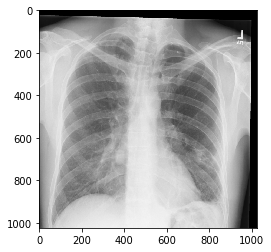

In [43]:
# Take a sample from the validation dataset (last 20%)
effusion_path = os.path.join(DATASET_PATH, disease_cls[0], '*')
effusion = glob.glob(effusion_path)
effusion = io.imread(effusion[-5])
plt.imshow(effusion,cmap='gray')

In [44]:
img = preprocess_img(effusion[:, :, np.newaxis], 'validation')
val_model.predict(img[np.newaxis,:])

array([[0.39867413, 0.60132587]], dtype=float32)